In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pylightgbm.models import GBMRegressor
import os

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016
os.environ["LIGHTGBM_EXEC"] = "C:/Users/Julien/LightGBM/lightgbm.exe"

#DATA = "Base"
DATA = "Time"
#DATA = "Medians"


In [2]:
# Get data
train = pd.read_csv("clean_data/train_" + DATA + ".csv")
y = pd.read_csv("clean_data/y.csv")

X_train = pd.read_csv("clean_data/X_train_" + DATA + ".csv")
y_train = pd.read_csv("clean_data/y_train.csv")

X_trainVal = pd.read_csv("clean_data/X_trainVal_" + DATA + ".csv")
y_trainVal = pd.read_csv("clean_data/y_trainVal.csv")

test = pd.read_csv("clean_data/test_" + DATA + ".csv")

X_test = pd.read_csv("clean_data/X_test_" + DATA + ".csv")
y_test = pd.read_csv("clean_data/y_test.csv")

X_testVal = pd.read_csv("clean_data/X_testVal_" + DATA + ".csv")
y_testVal = pd.read_csv("clean_data/y_testVal.csv")


In [3]:
# Definitions for LightGBM

def lgbm_mse(preds, dtrain) :
    labels = dtrain.get_label()
    return ("mse", mean_squared_error(preds, labels))

def run_lgbm(X_trainVal, y_trainVal, X_testVal, y_testVal, X_train, y_train) :
    # Train model
    lg = GBMRegressor(
        config = "",
        tree_learner = "serial", 
        application = "regression", 
        num_threads = N_JOBS,
        metric = "l2",
        learning_rate = 0.01,
        num_iterations = 20000,
        early_stopping_round = 100, 
        num_leaves = 500,
        min_data_in_leaf = 5,
        feature_fraction = 1,
        feature_fraction_seed = SEED,
        bagging_fraction = 1,
        bagging_freq = 100,
        bagging_seed = SEED,
        max_bin = 500,
        max_depth = 30,
        verbose = False
    )
    lg.fit(X_trainVal, y_trainVal, test_data = [(X_testVal, y_testVal)])
    
    print("LIGHTGBM best_round : " + str(lg.best_round))
    
    lg = GBMRegressor(
        config = "",
        tree_learner = "serial", 
        application = "regression", 
        num_threads = N_JOBS,
        metric = "l2",
        learning_rate = 0.01,
        num_iterations = int(lg.best_round / 0.67),
        num_leaves = 500,
        min_data_in_leaf = 5,
        feature_fraction = 1,
        feature_fraction_seed = SEED,
        bagging_fraction = 1,
        bagging_freq = 100,
        bagging_seed = SEED,
        max_bin = 500,
        max_depth = 30,
        verbose = False
    )
    lg.fit(X_train, y_train)

    return (lg)

In [4]:
# Generate y_test predictions to be able to optimize ensemble weights
lg = run_lgbm(X_trainVal, y_trainVal.TARGET, X_testVal, y_testVal.TARGET, X_train, y_train.TARGET)
preds_y_test = lg.predict(X_test) 

LIGHTGBM best_round : 284


In [5]:
# Show MSE on y_test
print("Average LGBM MSE on held-out fold : " + str(mean_squared_error(y_test.TARGET, preds_y_test)))


Average LGBM MSE on held-out fold : 110.296867735


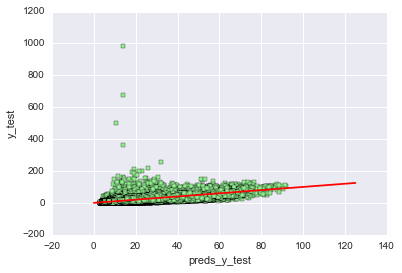

()

In [6]:
# Plot predictions
def plotPreds(preds, reals, xlbl, ylbl, dim) :
    plt.scatter(preds, reals, c = "lightgreen", marker = "s", label = "")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.plot([0, dim], [0, dim], c = "red")
    plt.show()
    return()

plotPreds(preds_y_test, y_test.TARGET, "preds_y_test", "y_test", 125)


In [7]:
# Save held-out fold predictions
y_test_name = "y_test_preds/LGBM_" + DATA + ".csv"
pd.DataFrame({"TARGET": preds_y_test}).to_csv(y_test_name, index = None, sep = ";")


In [8]:
# Now generate predictions on whole test set, to be used in ensemble for submissions
print("DATA : " + DATA)
lg = run_lgbm(X_train, y_train.TARGET, X_test, y_test.TARGET, train, y.TARGET)
preds_test = lg.predict(test.drop(["ID"], axis = 1)) 


DATA : Time
LIGHTGBM best_round : 12140


In [9]:
# Correct predictions for negative outputs
preds_test[preds_test < 0] = 0

In [10]:
# Save test set predictions
testID = pd.read_csv("clean_data/testID.csv", header = None)
test_name = "test_preds/LGBM_" + DATA + ".csv"
pd.DataFrame({"ID": testID[0], "TARGET": preds_test}, columns = ["ID", "TARGET"]).to_csv(test_name, index = None, sep = ";")